In [1]:
import numpy as np
import os
import pickle
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def load_jets(root_dir, filename):
    """Load truth binary trees"""
    #root_dir = "../data/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [3]:
lambda_truth = 2.4
pt_cut_truth = 30.0

In [111]:
gt_trees = load_jets("data", "ginkgo_10000_jets_no_cuts_lambda_{}_pt_min_{}_jetp_400_with_perm".format(int(lambda_truth*10),
                                                                                                      int(pt_cut_truth)))  # My test file

## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
arr = np.arange(len(gt_trees))
#good_indices = arr[((arr != 4835) & (arr != 9024))]
#gt_trees = (np.array(gt_trees)[good_indices]).tolist()

if lambda_truth == 2.4 and pt_cut_truth == 30.0 and Njets == 10000:
    arr = np.arange(len(gt_trees))
    good_indices = arr[arr != 2942]
    gt_trees = (np.array(gt_trees)[good_indices]).tolist()

## Load trellis grid results

In [4]:
time.time()

1624974162.7290094

In [36]:
def get_likelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                 Njets=10000,
                                 pt_cut=30.0,
                                 likelihood="marginal",
                                 datadir="/scratch/mdd424/data/trellis"):
    
    if likelihood.lower() == "marginal":
        key = "Z"
    elif likelihood.lower() == "map":
        key = "trellis_MLE"
    else:
        return None
    
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
        
    likelihood_surface = np.zeros((Njets, n_lambda))
    
    for i in range(n_lambda):
        model_params = {"delta_min": pt_cut, "lam": lambda_vals[i]}

        in_filename = os.path.join(datadir, "trellis_{}_jets_1D_lambda_{:n}_ptcut_{:n}_{}_with_perm.pkl".format(
            Njets,
            int(lambda_vals[i])*1000,
            int(pt_cut),
            i))
        with open(in_filename, "rb") as fd:
            results = pickle.load(fd, encoding='latin-1')

        ## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
        #myresults = np.array(results[key])
        #arr = np.arange(len(myresults))
        #good_indices = ((arr != 4835) & (arr != 9024))
        #myresults = myresults[good_indices]

        for k in range(Njets):
            likelihood_surface[k,i] = results[key][k]
                
    return likelihood_surface

In [146]:
seed = int(time.time()*1000) % 2**32

### THERE ARE TWO BAD JETS WITH INDICES (starting from 0)
- 4835
- 9024

In [147]:
arr = np.arange(10000)
((arr != 4835) & (arr != 9024)).sum()

9998

## Look at Results

In [7]:
n_lambda = 150
N_jets = 10000

#lambda_min = 1.6
#lambda_max = 2.75

lambda_min = 1.9
lambda_max = 3.05

lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)

### Get truth results

In [8]:
truth_bin = None
        
for ix, x in enumerate(lambda_vals >= lambda_truth):
    if x.item() is True:
        truth_bin = ix-1
        break
        
print(truth_bin)

64


In [23]:
lambda_vals[truth_bin], lambda_vals[truth_bin+1], lambda_truth

(2.393959731543624, 2.401677852348993, 2.4)

# Look at fit results across several minibatches

### Load all of the likelihood surfaces

In [128]:
Njets = 10000

likelihood_surface_array = get_likelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                                        Njets=Njets,
                                                        pt_cut=pt_cut_truth,
                                                        likelihood="marginal")
## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
arr = np.arange(likelihood_surface_array.shape[0])
#good_indices = arr[((arr != 4835) & (arr != 9024))]
#likelihood_surface_array = likelihood_surface_array[good_indices]

if lambda_truth == 2.4 and pt_cut_truth == 30.0 and Njets == 10000:
    arr = np.arange(likelihood_surface_array.shape[0])
    good_indices = arr[arr != 2942]
    likelihood_surface_array = likelihood_surface_array[good_indices]

### Randomly select minibatches

In [140]:
lambda_dists = []
chi2_dists = []
batch_mle_coords = []

batch_sizes = [50, 100, 200, 500, 1000]

arr = np.arange(likelihood_surface_array.shape[0])

nbatches = 1000

for batch_size in batch_sizes:
    
    lambda_dist = []
    chi2_dist = []
    for seed in range(nbatches):
        np.random.seed(seed)

        random_indices = np.random.choice(arr, batch_size, replace=False)

        batch_likelihood_surface = np.sum(likelihood_surface_array[random_indices], axis=0)

        batch_mle_coord = np.unravel_index(np.argmax(batch_likelihood_surface[~np.isnan(batch_likelihood_surface)], axis=None),
                                      batch_likelihood_surface.shape)[0]

        Z = -2*(batch_likelihood_surface-batch_likelihood_surface[batch_mle_coord])

        batch_mle_coords.append(batch_mle_coord)
        chi2_dist.append(Z[truth_bin])
        lambda_dist.append(lambda_vals[batch_mle_coord])
        
    lambda_dist = np.array(lambda_dist)
    chi2_dist = np.array(chi2_dist)
    
    lambda_dists.append(lambda_dist)
    chi2_dists.append(chi2_dist)

In [142]:
lambda_min_bin = len(lambda_vals)
lambda_max_bin = 0

for i in range(len(batch_sizes)):
    for ix, x in enumerate(lambda_vals == np.min(lambda_dists[i][lambda_dists[i] != None])):
        if x.item() is True:
            lambda_min_bin = min(ix, lambda_min_bin)
            break

    for ix, x in enumerate(lambda_vals == np.max(lambda_dists[i][lambda_dists[i] != None])):
        if x.item() is True:
            lambda_max_bin = max(ix, lambda_max_bin)
            break
        
lambda_hist_bins = lambda_vals[lambda_min_bin:lambda_max_bin+2]

Text(0.5, 1.0, 'Distribution of Parameter Trellis MLEs for Different Batch Sizes')

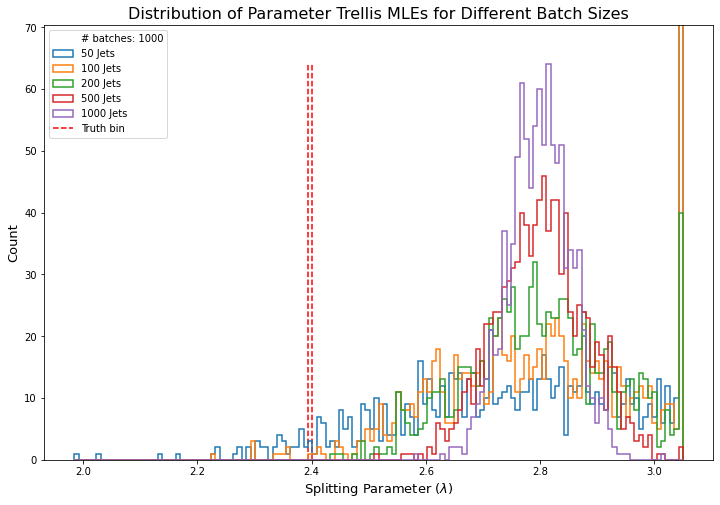

In [151]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12,8)

ymax = 0

for i in range(len(batch_sizes)):
    hist1 = ax1.hist(lambda_dists[i][lambda_dists[i] != None],
                     bins=lambda_hist_bins,
                     histtype="step", linewidth=1.5, label="{} Jets".format(batch_sizes[i]))
    ymax = max(ymax, np.max(hist1[0][:-1]))
    

ax1.vlines(lambda_vals[truth_bin], ymin=0, ymax=ymax, colors="red", linestyle="dashed",
           linewidth=1.5, label="Truth bin")
ax1.vlines(lambda_vals[truth_bin+1], ymin=0, ymax=ymax, colors="red", linestyle="dashed", linewidth=1.5)
ax1.plot([], [], ' ', label="# batches: {}".format(nbatches))
#ax1.plot([], [], ' ', label="batch size: {}".format(batch_size))

ax1.legend(loc="upper left")

ax1.set_ylim([0, ymax*1.1])

ax1.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax1.set_ylabel("Count", size=13)
ax1.set_title("Distribution of Parameter Trellis MLEs for Different Batch Sizes", size=16)
#ax1.set_title("Distribution of Jet Likelihoods", size=15)

Text(0.5, 1.0, 'Distribution of -2log (L(truth) / L(MLE)) for the Batch MLEs')

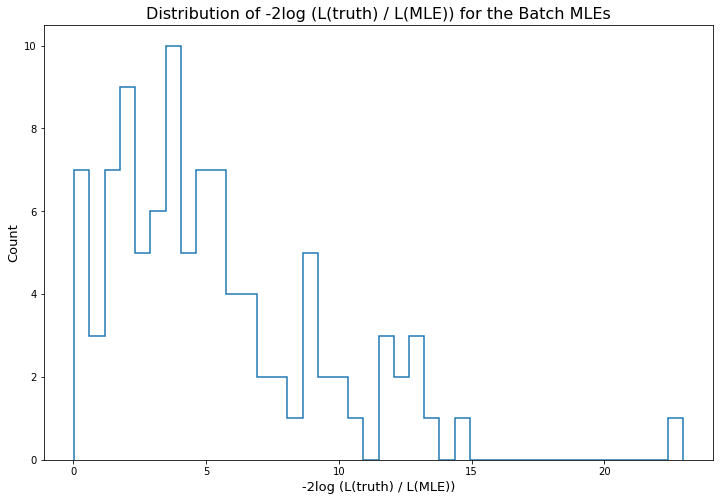

In [133]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12,8)

hist1 = ax1.hist(chi2_dist[chi2_dist != None],
                 bins=40,
                 histtype="step", linewidth=1.5)

ax1.set_xlabel("-2log (L(truth) / L(MLE))", size=13)
ax1.set_ylabel("Count", size=13)
ax1.set_title("Distribution of -2log (L(truth) / L(MLE)) for the Batch MLEs", size=16)
#ax1.set_title("Distribution of Jet Likelihoods", size=15)

In [83]:
np.var([x for x in lambda_dist if x is not None])

0.024921902211612078

In [84]:
total_likelihood_surface = np.sum(likelihood_surface_array, axis=0)

In [85]:
mle_coords = np.unravel_index(np.argmax(total_likelihood_surface[~np.isnan(total_likelihood_surface)], axis=None),
                                  total_likelihood_surface.shape)[0]
mle_coords

116

In [86]:
Z = -2*(total_likelihood_surface-total_likelihood_surface.max())

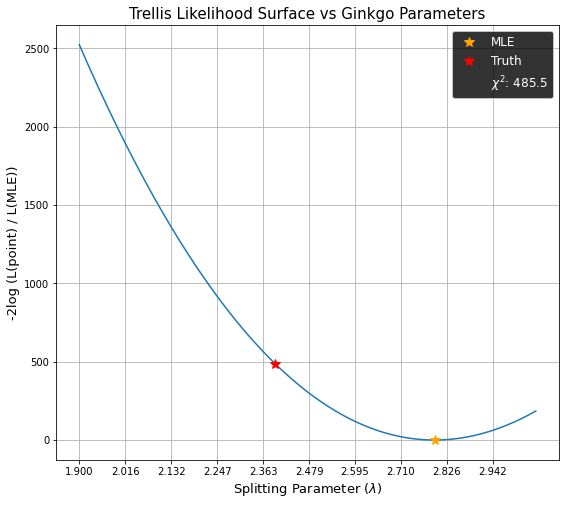

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(total_likelihood_surface-total_likelihood_surface.max())

chi2_marginal = Z[truth_bin]

ax.plot(lambda_vals, Z)
ax.plot(lambda_vals[mle_coords], Z[mle_coords], '*', color="orange", label="MLE", markersize=10)
#for coords in batch_mle_coords:
#    ax.plot(lambda_vals[coords], Z[coords], "*", color="orange", markersize=9)
ax.plot(lambda_vals[truth_bin], Z[truth_bin], '*', label="Truth", markersize=10, color="red")
ax.plot([], [], ' ', label="$\chi^2$: {:.1f}".format(chi2_marginal))


ax.legend(labelcolor="white", facecolor="black", fontsize="large")
ax.grid()

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("-2log (L(point) / L(MLE))", size=13)
ax.set_xticks(lambda_vals[::15]);

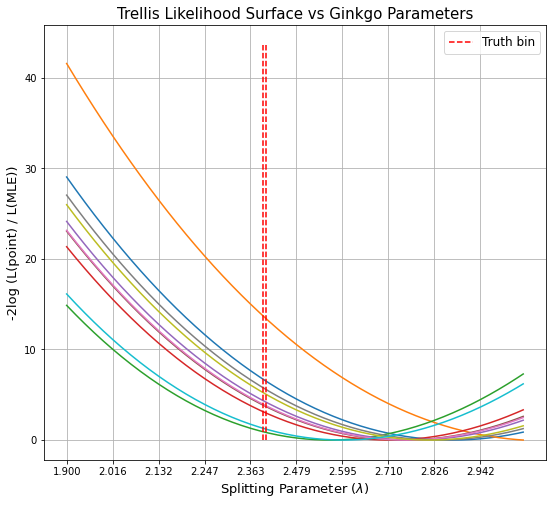

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

arr = np.arange(likelihood_surface_array.shape[0])

for seed in range(30, 40):
    np.random.seed(seed)

    random_indices = np.random.choice(arr, 100, replace=False)

    batch_likelihood_surface = np.sum(likelihood_surface_array[random_indices], axis=0)
    Z = -2*(batch_likelihood_surface-batch_likelihood_surface.max())

    ax.plot(lambda_vals, Z)
    
y_min, y_max = ax.get_ylim()
    
ax.vlines(lambda_vals[truth_bin], ymin=0, ymax=y_max, colors="red", linestyle="dashed",
           linewidth=1.5, label="Truth bin", zorder=1e4)
ax.vlines(lambda_vals[truth_bin+1], ymin=0, ymax=y_max, colors="red", linestyle="dashed", linewidth=1.5, zorder=1e4)

ax.grid()
ax.legend(fontsize="large")

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("-2log (L(point) / L(MLE))", size=13)
ax.set_xticks(lambda_vals[::15]);

# Look at results over different numbers of batches and batch sizes

In [95]:
Njets = 10000

likelihood_surface_array = get_likelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                                        Njets=Njets,
                                                        pt_cut=pt_cut_truth,
                                                        likelihood="marginal")
## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
arr = np.arange(likelihood_surface_array.shape[0])
#good_indices = arr[((arr != 4835) & (arr != 9024))]
#likelihood_surface_array = likelihood_surface_array[good_indices]

if lambda_truth == 2.4 and pt_cut_truth == 30.0 and Njets == 10000:
    arr = np.arange(likelihood_surface_array.shape[0])
    good_indices = arr[arr != 2942]
    likelihood_surface_array = likelihood_surface_array[good_indices]

In [234]:
def get_mean_mle(likelihood_surface_array, nbatch, batch_size):
    arr = np.arange(likelihood_surface_array.shape[0])

    lambda_dist = []
    for seed in range(nbatch):    
        random_indices = np.random.choice(arr, batch_size, replace=False)

        batch_likelihood_surface = np.sum(likelihood_surface_array[random_indices], axis=0)
        Z = -2*(batch_likelihood_surface-batch_likelihood_surface.max())

        mle_coords = np.unravel_index(np.argmax(batch_likelihood_surface[~np.isnan(batch_likelihood_surface)], axis=None),
                                      batch_likelihood_surface.shape)[0]

        lambda_dist.append(lambda_vals[mle_coords])
    return np.mean(lambda_dist)

In [ ]:
n_nbatch = 30
nbatch_min = 10
nbatch_max = 1000


n_batch_size = 30
batch_size_min = 1
batch_size_max = 1000

nbatch_vals = np.linspace(nbatch_min, nbatch_max, n_nbatch, dtype=int)
batch_size_vals = np.linspace(batch_size_min, batch_size_max, n_batch_size, dtype=int)

grid_nbatch, grid_batch_size = np.meshgrid(nbatch_vals, batch_size_vals)

In [255]:
mle_vals = np.zeros((n_nbatch, n_batch_size))

for i in range(n_nbatch):
    for j in range(n_batch_size):
        mle_vals[i,j] = get_mean_mle(likelihood_surface_array, nbatch_vals[i], batch_size_vals[j])

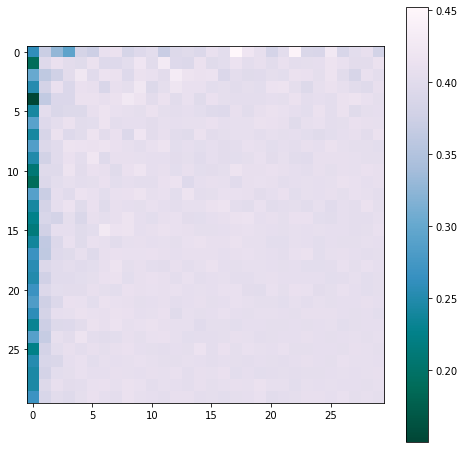

In [256]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

im = ax.imshow(abs(mle_vals - 2.1), cmap="PuBuGn_r")
cb = fig.colorbar(im, ax=ax)
cb.set_label(label="", size=18)

In [257]:
abs(mle_vals - 2.1)[0, 27], abs(mle_vals - 2.1)[27, 0]

(0.4037919463087247, 0.2455074647308586)

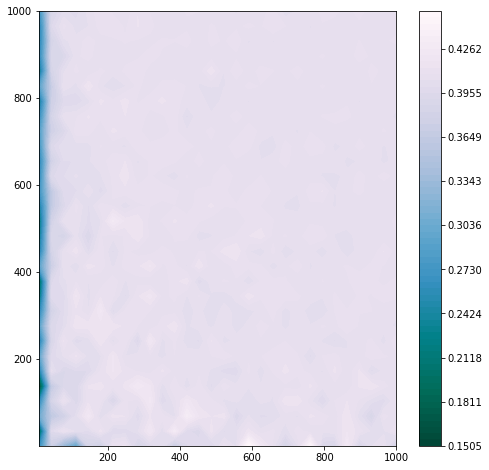

In [258]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

z = abs(mle_vals - 2.1)

levels = np.linspace(z.min(), z.max(), 70)

cset1 = ax.contourf(grid_nbatch, grid_batch_size, z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="", size=18)

# Load leaf-based grid results

In [152]:
def get_leaf_likelihood_surface_array(gt_trees, lambda_min, lambda_max, n_lambda,
                                 Njets=10000, pt_cut=30.0, datadir="/scratch/mdd424/data/ginkgo"):
    
    Njets = min(Njets, len(gt_trees))
    
    train_leaves_ix = [len(x["leaves"])-1 for x in gt_trees[:Njets]]
    
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
        
    logLikelihood_surface = np.zeros((Njets, n_lambda))

    for i in range(n_lambda):
        model_params = {"delta_min": pt_cut, "lam": lambda_vals[i]}

        histfile = "ginkgo_hist_20000_jets_1D_jetp_400_lambda_{:n}_ptcut_{:n}_{}.npy".format(
            int(lambda_vals[i])*1000,
            int(pt_cut),
            i)

        dist = np.load(os.path.join("/scratch/mdd424/data/ginkgo", histfile))
        #dist += 1/20000
        #dist = dist / dist.sum()
        log_dist = np.log(dist)

        for k in range(Njets):
            logLikelihood_surface[k,i] = log_dist[train_leaves_ix[k]]
                
    return logLikelihood_surface

In [153]:
def get_mean_leaves(lambda_min, lambda_max, n_lambda,
                    pt_cut=30.0, datadir="/scratch/mdd424/data/ginkgo"):
    
        
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
    
    mean_leaves = []
        
    for i in range(n_lambda):
        histfile = "ginkgo_hist_20000_jets_1D_jetp_400_lambda_{:n}_ptcut_{:n}_{}.npy".format(
            int(lambda_vals[i])*1000,
            int(pt_cut),
            i)

        dist = np.load(os.path.join("/scratch/mdd424/data/ginkgo", histfile))
        mean_leaves.append(np.sum(dist*np.arange(1, len(dist)+1)))
                
    return mean_leaves

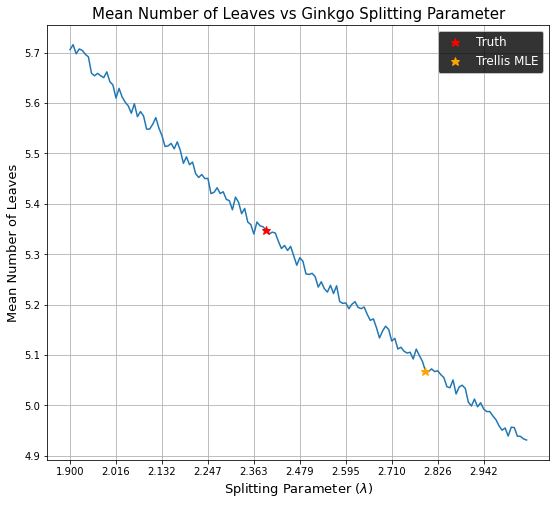

In [154]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

mean_leaves_dist = get_mean_leaves(lambda_min, lambda_max, n_lambda)

ax.plot(lambda_vals, mean_leaves_dist)
ax.plot(lambda_vals[truth_bin], mean_leaves_dist[truth_bin], "*", color="red", label="Truth", markersize=9)
ax.plot(lambda_vals[mle_coords], mean_leaves_dist[mle_coords], "*", color="orange", label="Trellis MLE", markersize=9)

ax.grid()
ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Mean Number of Leaves vs Ginkgo Splitting Parameter", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("Mean Number of Leaves", size=13)
#ax.set_yscale("log")
ax.set_xticks(lambda_vals[::15]);

In [158]:
n_lambda = 150
N_jets = 10000

lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)

leaf_likelihood_surface_array = get_leaf_likelihood_surface_array(gt_trees,
                                                                  lambda_min, lambda_max, n_lambda,
                                                                  Njets=N_jets, pt_cut=pt_cut_truth)

total_leaf_likelihood_surface = np.sum(leaf_likelihood_surface_array, axis=0)

<ipython-input-152-d1423e2f4e43>:23: RuntimeWarning: divide by zero encountered in log
  log_dist = np.log(dist)


In [159]:
mle_leaf_coords = np.unravel_index(np.argmax(total_leaf_likelihood_surface[~np.isnan(total_leaf_likelihood_surface)], axis=None), total_leaf_likelihood_surface.shape)[0]
mle_leaf_coords

62

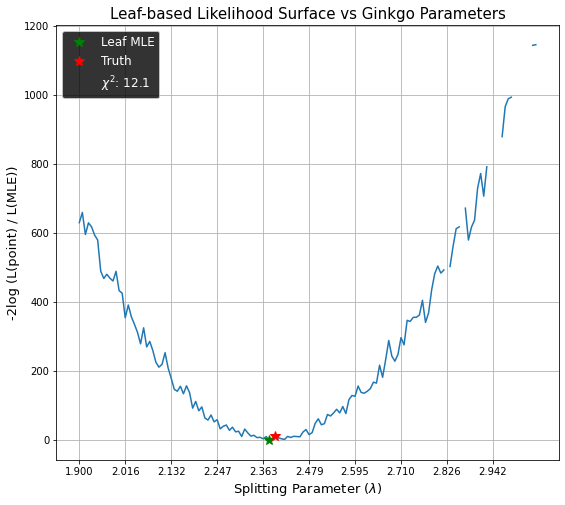

In [160]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(total_leaf_likelihood_surface-total_leaf_likelihood_surface[mle_leaf_coords])

chi2_marginal = Z[truth_bin]

ax.plot(lambda_vals, Z)
ax.plot(lambda_vals[mle_leaf_coords], Z[mle_leaf_coords], '*', color="green", label="Leaf MLE", markersize=10)
#ax.plot(lambda_vals[mle_coords], Z[mle_coords], '*', color="orange", label="MLE", markersize=10)
ax.plot(lambda_vals[truth_bin], Z[truth_bin], '*', label="Truth", markersize=10, color="red")
ax.plot([], [], ' ', label="$\chi^2$: {:.1f}".format(chi2_marginal))


ax.legend(labelcolor="white", facecolor="black", fontsize="large")
ax.grid()

ax.set_title("Leaf-based Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("-2log (L(point) / L(MLE))", size=13)
#ax.set_yscale("log")
ax.set_xticks(lambda_vals[::15]);

## Look at the distribution of leaves

In [44]:
trellis_mle_jets = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_20000_jets_1D_jetp_400_lambda_{:n}_ptcut_{:n}_{}".format(
    int(lambda_vals[mle_coords])*1000,
    int(36.0),
    mle_coords))

In [46]:
trellis_mle_histfile = "ginkgo_hist_20000_jets_1D_jetp_400_lambda_{:n}_ptcut_{:n}_{}.npy".format(
            int(lambda_vals[mle_coords])*1000,
            int(36),
            mle_coords)

trellis_mle_dist = np.load(os.path.join("/scratch/mdd424/data/ginkgo", trellis_mle_histfile))

In [69]:
leaf_mle_jets = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_20000_jets_1D_jetp_400_lambda_{:n}_ptcut_{:n}_{}".format(
    int(lambda_vals[mle_leaf_coords])*1000,
    int(36.0),
    mle_leaf_coords))

In [73]:
leaf_mle_histfile = "ginkgo_hist_20000_jets_1D_jetp_400_lambda_{:n}_ptcut_{:n}_{}.npy".format(
            int(lambda_vals[mle_leaf_coords])*1000,
            int(36),
            mle_leaf_coords)

leaf_mle_dist = np.load(os.path.join("/scratch/mdd424/data/ginkgo", leaf_mle_histfile))

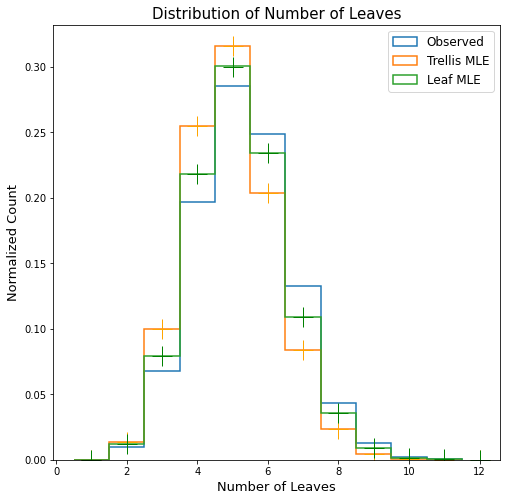

In [76]:
truth_num_leaves = [len(x["leaves"]) for x in gt_trees[:10000]]
trellis_num_leaves = [len(x["leaves"]) for x in trellis_mle_jets]
leaf_num_leaves = [len(x["leaves"]) for x in leaf_mle_jets]

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

ax.hist(truth_num_leaves, bins=np.arange(1,13)-0.5, histtype="step", linewidth=1.5, density=True, label="Observed")
ax.hist(trellis_num_leaves, bins=np.arange(1,13)-0.5, histtype="step", linewidth=1.5,  density=True, label="Trellis MLE")
ax.hist(leaf_num_leaves, bins=np.arange(1,13)-0.5, histtype="step", linewidth=1.5,  density=True, label="Leaf MLE")
ax.plot(np.arange(1,13), trellis_mle_dist[:12], "+", markersize=20, color="orange")
ax.plot(np.arange(1,13), leaf_mle_dist[:12], "+", markersize=20, color="green")

ax.set_xlabel("Number of Leaves", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Number of Leaves", size=15)
ax.legend(fontsize="large")

In [56]:
np.mean(trellis_num_leaves), np.sum(trellis_mle_dist*np.arange(1, len(trellis_mle_dist)+1))

(4.9664, 4.9664)

# Fits for jets with certain numbers of leaves

### Without the $p(N | lambda)$ term

In [120]:
num_leaves = np.array([tree["leaves"].shape[0] for tree in gt_trees])

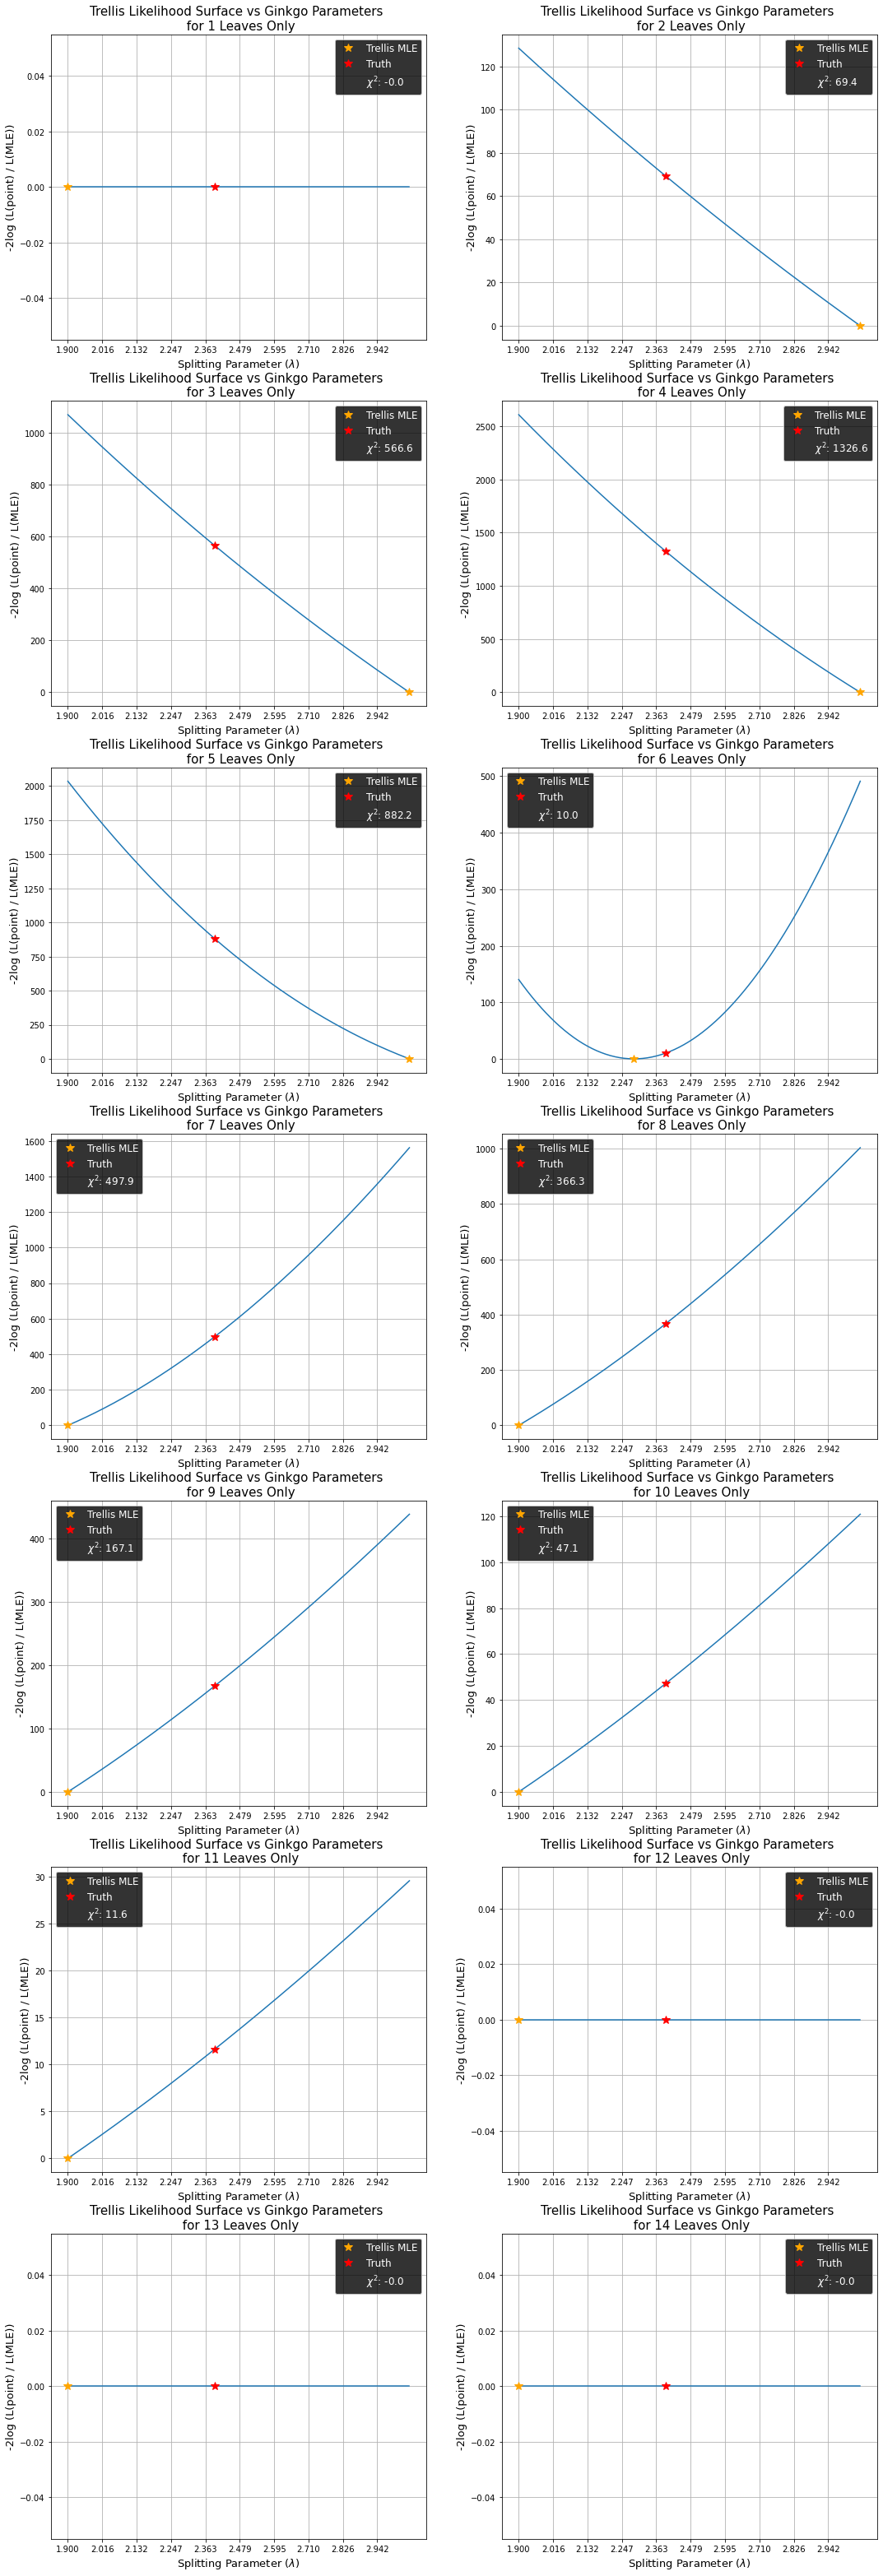

In [119]:
fig, ax = plt.subplots(nrows=7, ncols=2)
fig.set_size_inches(18,56)

leaf_choices = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]])

for ax_x in range(7):
    for ax_y in range(2):
        
        batch_likelihood_surface = np.sum(likelihood_surface_array[num_leaves == leaf_choices[ax_x, ax_y]], axis=0)
        
        batch_mle_coords = np.unravel_index(np.argmax(batch_likelihood_surface[~np.isnan(batch_likelihood_surface)], axis=None), batch_likelihood_surface.shape)[0]

        Z = -2*(batch_likelihood_surface-batch_likelihood_surface[batch_mle_coords])

        batch_chi2_marginal = Z[truth_bin]

        ax[ax_x,ax_y].plot(lambda_vals, Z)
        ax[ax_x,ax_y].plot(lambda_vals[batch_mle_coords], Z[batch_mle_coords], '*', color="orange", label="Trellis MLE", markersize=10)
        ax[ax_x,ax_y].plot(lambda_vals[truth_bin], Z[truth_bin], '*', label="Truth", markersize=10, color="red")
        ax[ax_x,ax_y].plot([], [], ' ', label="$\chi^2$: {:.1f}".format(batch_chi2_marginal))


        ax[ax_x,ax_y].legend(labelcolor="white", facecolor="black", fontsize="large")
        ax[ax_x,ax_y].grid()

        ax[ax_x,ax_y].set_title("Trellis Likelihood Surface vs Ginkgo Parameters \n for {} Leaves Only".format(leaf_choices[ax_x, ax_y]), size=15)
        ax[ax_x,ax_y].set_xlabel("Splitting Parameter ($\lambda$)", size=13)
        ax[ax_x,ax_y].set_ylabel("-2log (L(point) / L(MLE))", size=13)
        ax[ax_x,ax_y].set_xticks(lambda_vals[::15]);

In [121]:
num_leaves = np.array([tree["leaves"].shape[0] for tree in gt_trees])
num_leaves_pairs = [(x, (num_leaves == x).sum()) for x in range(1, 119)]
num_leaves_pairs[:15]

[(1, 0),
 (2, 95),
 (3, 679),
 (4, 1965),
 (5, 2855),
 (6, 2486),
 (7, 1329),
 (8, 435),
 (9, 125),
 (10, 25),
 (11, 5),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0)]

### With the $p(N | lambda)$ term

In [126]:
leaf_distro = np.zeros((118, n_lambda))  # first index is the number of leaves - 1

for i in range(n_lambda):        
    histfile = "ginkgo_hist_20000_jets_1D_jetp_400_lambda_{:n}_ptcut_{:n}_{}.npy".format(
        int(lambda_vals[i])*1000,
        int(30.0),
        i)

    dist = np.load(os.path.join("/scratch/mdd424/data/ginkgo", histfile))
    dist += 1/20000
    dist = dist / dist.sum()
    log_dist = np.log(dist)

    leaf_distro[:,i] = log_dist

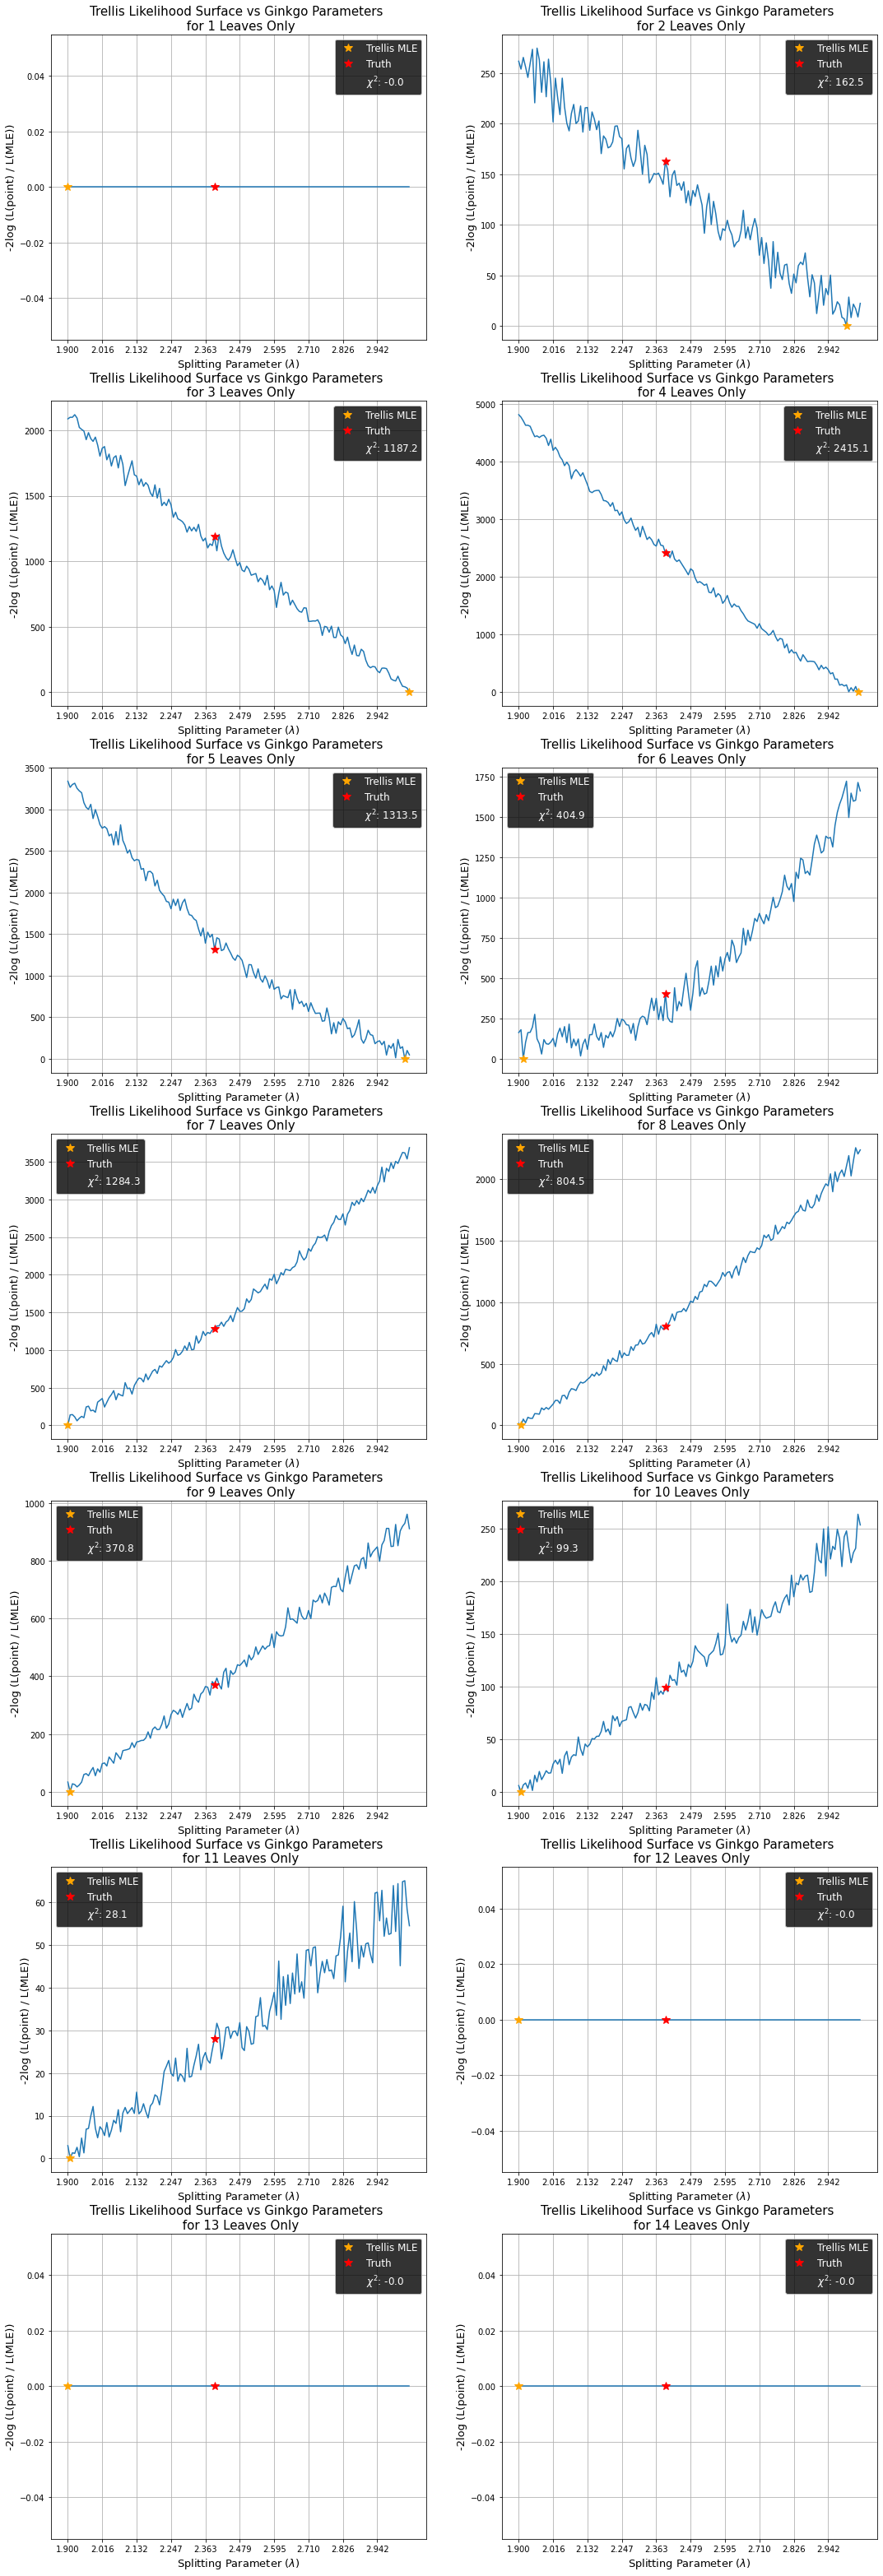

In [127]:
fig, ax = plt.subplots(nrows=7, ncols=2)
fig.set_size_inches(18,56)

leaf_choices = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]])

for ax_x in range(7):
    for ax_y in range(2):
        
        batch_likelihood_surface = np.sum(likelihood_surface_array[num_leaves == leaf_choices[ax_x, ax_y]], axis=0)
        batch_likelihood_surface += leaf_distro[leaf_choices[ax_x, ax_y] - 1]*num_leaves_pairs[leaf_choices[ax_x, ax_y] - 1][1]
        
        batch_mle_coords = np.unravel_index(np.argmax(batch_likelihood_surface[~np.isnan(batch_likelihood_surface)], axis=None), batch_likelihood_surface.shape)[0]

        Z = -2*(batch_likelihood_surface-batch_likelihood_surface[batch_mle_coords])

        batch_chi2_marginal = Z[truth_bin]

        ax[ax_x,ax_y].plot(lambda_vals, Z)
        ax[ax_x,ax_y].plot(lambda_vals[batch_mle_coords], Z[batch_mle_coords], '*', color="orange", label="Trellis MLE", markersize=10)
        ax[ax_x,ax_y].plot(lambda_vals[truth_bin], Z[truth_bin], '*', label="Truth", markersize=10, color="red")
        ax[ax_x,ax_y].plot([], [], ' ', label="$\chi^2$: {:.1f}".format(batch_chi2_marginal))


        ax[ax_x,ax_y].legend(labelcolor="white", facecolor="black", fontsize="large")
        ax[ax_x,ax_y].grid()

        ax[ax_x,ax_y].set_title("Trellis Likelihood Surface vs Ginkgo Parameters \n for {} Leaves Only".format(leaf_choices[ax_x, ax_y]), size=15)
        ax[ax_x,ax_y].set_xlabel("Splitting Parameter ($\lambda$)", size=13)
        ax[ax_x,ax_y].set_ylabel("-2log (L(point) / L(MLE))", size=13)
        ax[ax_x,ax_y].set_xticks(lambda_vals[::15]);